# PREDICCIÓN DEL PRECIOS DE ACTIVOS FINANCIEROS EMPLEANDO APRENDIZAJE AUTOMÁTICO
#### Autor: Samuel Valer Nasta

# Librerías empleadas

In [1]:
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns   
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, get_scorer_names
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential, save_model, load_model
from keras.layers import Dense, LSTM, Dropout, GRU
from keras.layers import *
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from keras.wrappers.scikit_learn import KerasRegressor

# Obtención y análisis de datos

In [2]:
fecha_inicio = '2000-01-01'
fecha_fin = '2023-05-01'

datos_tesla = yf.download('TSLA', start=fecha_inicio, end=fecha_fin)
datos_sp500 = yf.download('^GSPC', start=fecha_inicio, end=fecha_fin)
datos_bitcoin = yf.download('BTC-USD', start=fecha_inicio, end=fecha_fin)
datos_petroleo = yf.download('CL=F', start=fecha_inicio, end=fecha_fin)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Preprocesamiento de datos

In [3]:
datos_sp500.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,1469.250000,1478.000000,1438.359985,1455.219971,1455.219971,931800000
2000-01-04,1455.219971,1455.219971,1397.430054,1399.420044,1399.420044,1009000000
2000-01-05,1399.420044,1413.270020,1377.680054,1402.109985,1402.109985,1085500000
2000-01-06,1402.109985,1411.900024,1392.099976,1403.449951,1403.449951,1092300000
2000-01-07,1403.449951,1441.469971,1400.729980,1441.469971,1441.469971,1225200000


Comprobamos si hay datos nulos o na.

In [4]:
print(datos_tesla.isnull().sum())
print(datos_tesla.isna().any())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool


In [5]:
print(datos_sp500.isnull().sum())
print(datos_sp500.isna().any())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool


In [6]:
print(datos_bitcoin.isnull().sum())
print(datos_bitcoin.isna().any())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool


In [7]:
print(datos_petroleo.isnull().sum())
print(datos_petroleo.isna().any())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool


## Análisis exploratiorio

### Gráfico de lineas

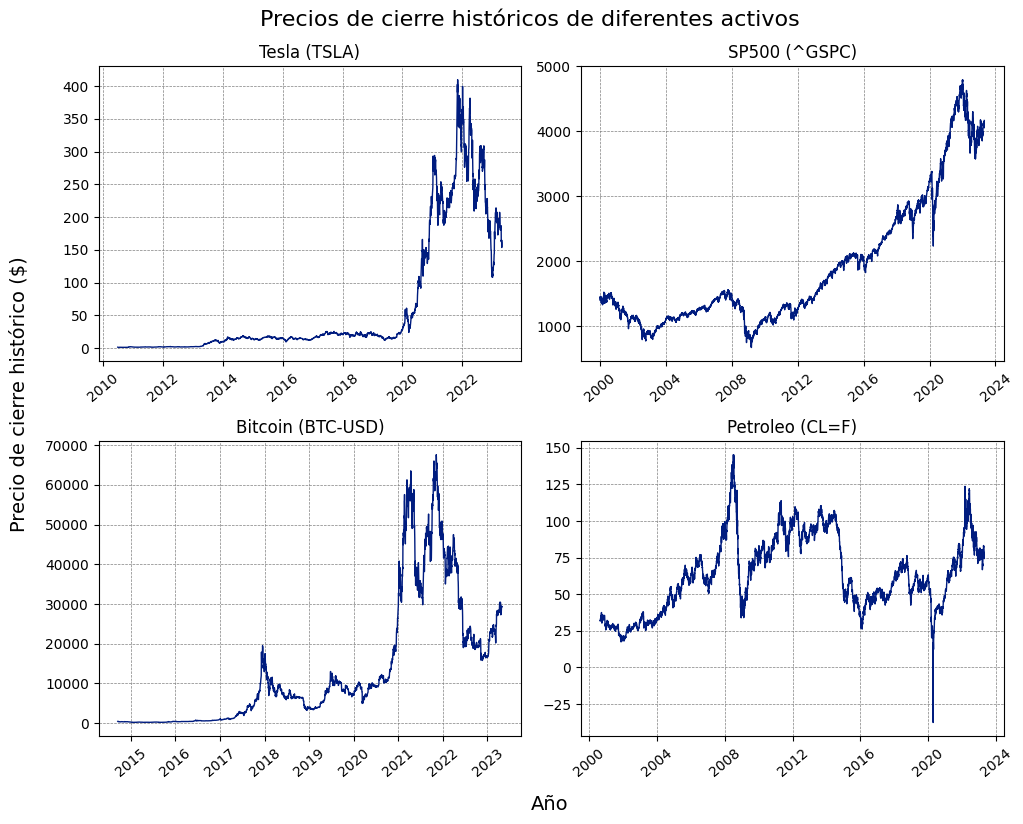

In [8]:
sns.set_palette('dark')

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
for ax in axs.flat:
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')

axs[0, 0].plot(datos_tesla['Adj Close'], linewidth=1)
axs[0, 0].set_title('Tesla (TSLA)')
axs[0, 1].plot(datos_sp500['Adj Close'], linewidth=1)
axs[0, 1].set_title('SP500 (^GSPC)')
axs[1, 0].plot(datos_bitcoin['Adj Close'], linewidth=1)
axs[1, 0].set_title('Bitcoin (BTC-USD)')
axs[1, 1].plot(datos_petroleo['Adj Close'], linewidth=1)
axs[1, 1].set_title('Petroleo (CL=F)')

for ax in axs.flat:
    ax.tick_params(axis='x', labelrotation=40)

fig.text(0.52, -0.02, 'Año', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precio de cierre histórico ($)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Precios de cierre históricos de diferentes activos', fontsize=16)

plt.tight_layout()
plt.show()


Aqui vemos como en 2020 hubo un problema por lo que lo vamos a prescindir de estos datos.

### Gráfico de lineas de todas las variables de cada activo en una temporalidad menor

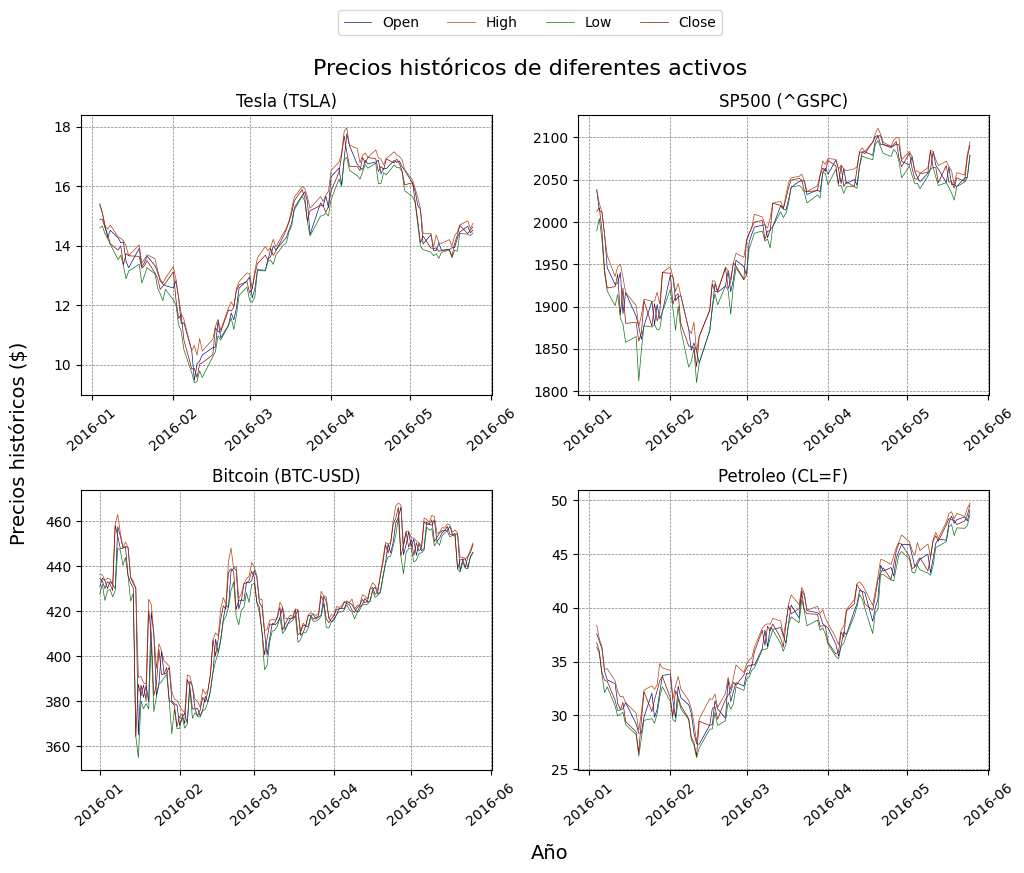

In [9]:
sns.set_palette('dark')

fecha_inicio_plot = '2016-01-01'
fecha_fin_plot = '2016-05-25'

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
axs = axs.flatten()

datos = [datos_tesla, datos_sp500, datos_bitcoin, datos_petroleo]
titulos = ['Tesla (TSLA)', 'SP500 (^GSPC)', 'Bitcoin (BTC-USD)', 'Petroleo (CL=F)']
etiquetas = ['Open', 'High', 'Low', 'Close']  # etiquetas para la leyenda

for i, ax in enumerate(axs):
    ax.set_title(titulos[i])
    for j, etiqueta in enumerate(etiquetas):
        ax.plot(datos[i].loc[fecha_inicio_plot:fecha_fin_plot, etiqueta], linewidth=0.5, label=etiqueta)
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')
    ax.tick_params(axis='x', labelrotation=40)

fig.text(0.52, -0.02, 'Año', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Precios históricos ($)', va='center', rotation='vertical', fontsize=14) 
fig.suptitle('Precios históricos de diferentes activos', fontsize=16)

fig.legend(etiquetas, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4)  # añade leyenda general para todo el gráfico

plt.tight_layout()
plt.show()


### Retornos diarios

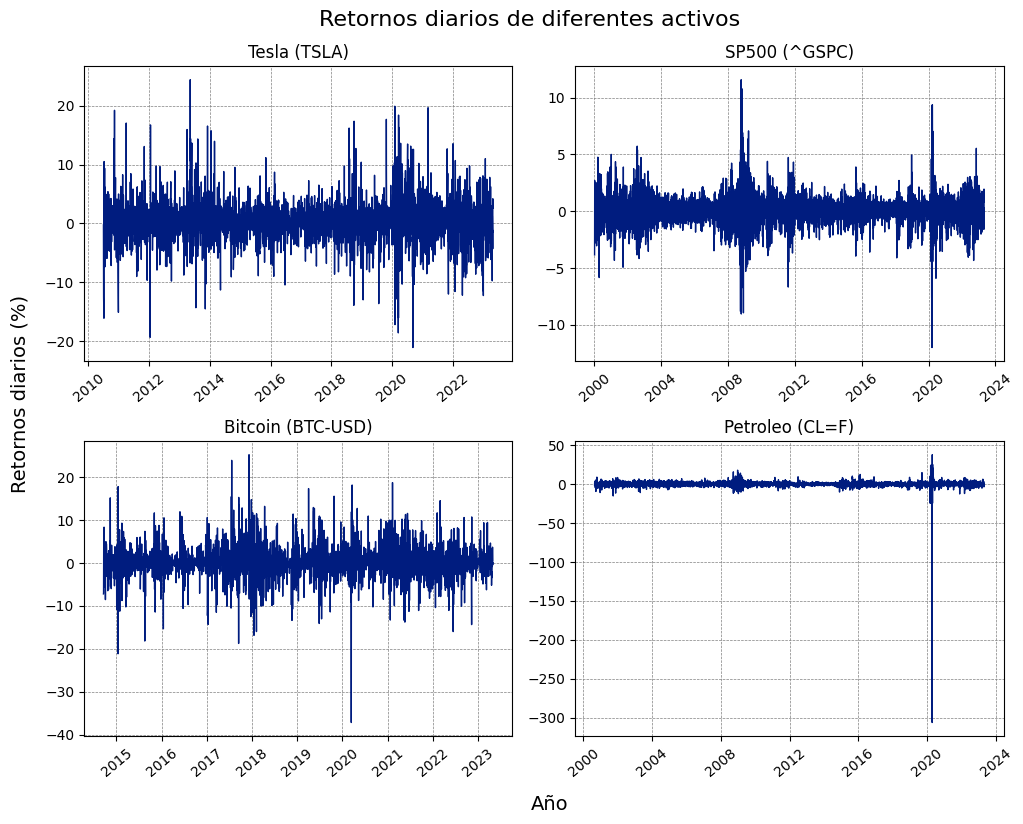

In [10]:
sns.set_palette('dark')

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
for ax in axs.flat:
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')

axs[0, 0].plot(datos_tesla['Adj Close'].pct_change()*100, linewidth=1)
axs[0, 0].set_title('Tesla (TSLA)')
axs[0, 1].plot(datos_sp500['Adj Close'].pct_change()*100, linewidth=1)
axs[0, 1].set_title('SP500 (^GSPC)')
axs[1, 0].plot(datos_bitcoin['Adj Close'].pct_change()*100, linewidth=1)
axs[1, 0].set_title('Bitcoin (BTC-USD)')
axs[1, 1].plot(datos_petroleo['Adj Close'].pct_change()*100, linewidth=1)
axs[1, 1].set_title('Petroleo (CL=F)')

for ax in axs.flat:
    ax.tick_params(axis='x', labelrotation=40)

fig.text(0.52, -0.02, 'Año', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Retornos diarios (%)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Retornos diarios de diferentes activos', fontsize=16)

plt.tight_layout()
plt.show()


### Volatilidad en ventanas de 15 dias

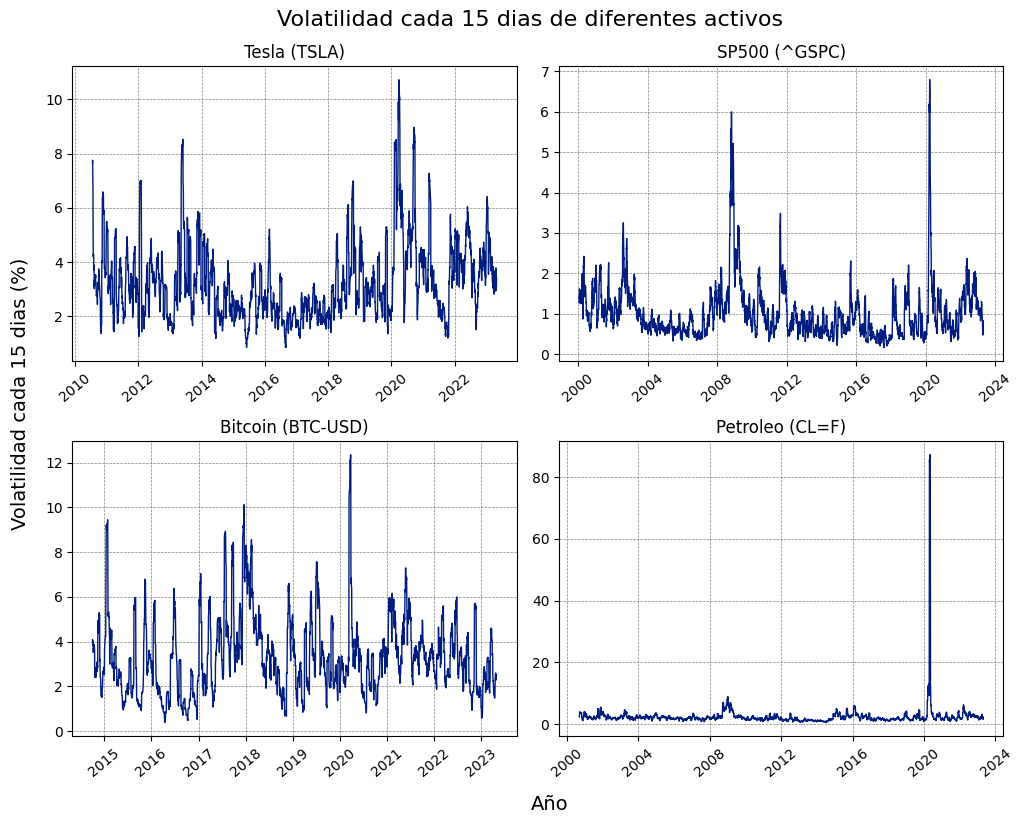

In [11]:
sns.set_palette('dark')

# Calcular la volatilidad diaria en ventanas de tiempo
window = 15
volatility_tesla = datos_tesla['Adj Close'].pct_change().rolling(window=window).std() * 100
volatility_sp500 = datos_sp500['Adj Close'].pct_change().rolling(window=window).std() * 100
volatility_bitcoin = datos_bitcoin['Adj Close'].pct_change().rolling(window=window).std() * 100
volatility_petroleo = datos_petroleo['Adj Close'].pct_change().rolling(window=window).std() * 100

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
for ax in axs.flat:
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')

axs[0, 0].plot(volatility_tesla, linewidth=1)
axs[0, 0].set_title('Tesla (TSLA)')
axs[0, 1].plot(volatility_sp500, linewidth=1)
axs[0, 1].set_title('SP500 (^GSPC)')
axs[1, 0].plot(volatility_bitcoin, linewidth=1)
axs[1, 0].set_title('Bitcoin (BTC-USD)')
axs[1, 1].plot(volatility_petroleo, linewidth=1)
axs[1, 1].set_title('Petroleo (CL=F)')

for ax in axs.flat:
    ax.tick_params(axis='x', labelrotation=40)
fig.text(0.52, -0.02, 'Año', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Volatilidad cada 15 dias (%)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Volatilidad cada 15 dias de diferentes activos', fontsize=16)

plt.tight_layout()
plt.show()

### Máximo Drawdown en 15 dias

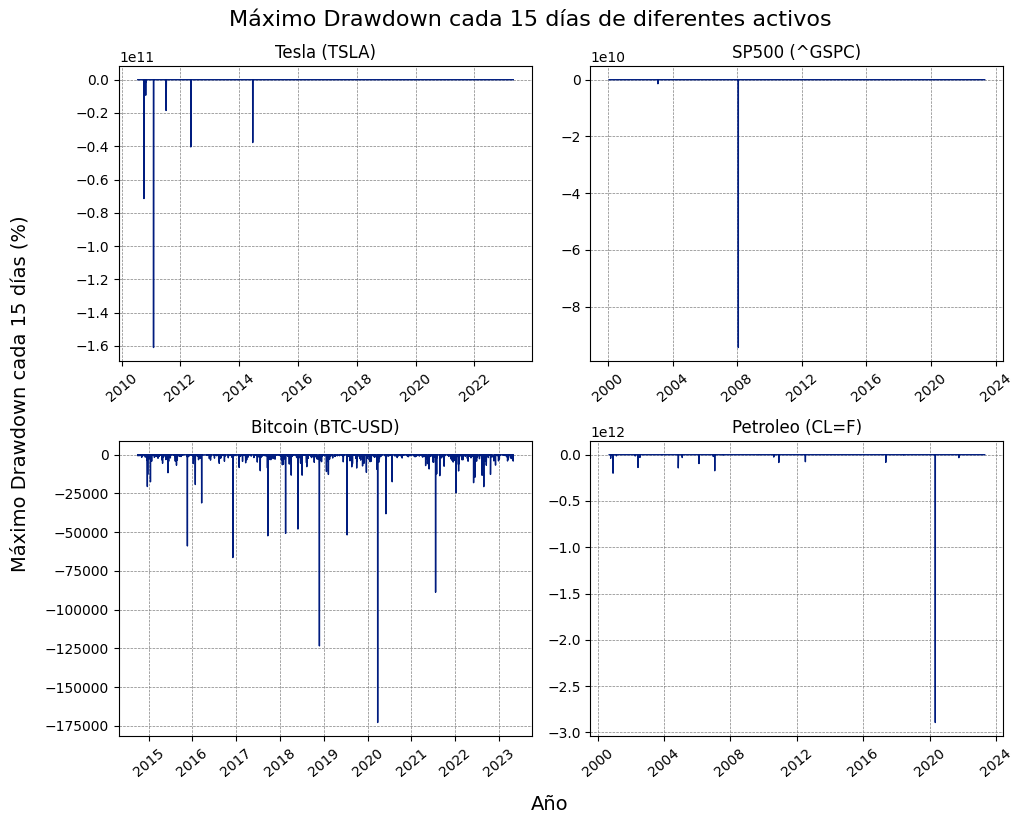

In [12]:
def max_drawdown(data):
    """
    Función para calcular el Máximo Drawdown de un conjunto de datos.
    """
    cum_returns = np.cumprod(1 + data) - 1
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / (peak + 1e-10)
    max_drawdown = drawdown.min()
    return max_drawdown

# Calcular el Máximo Drawdown en ventanas de tiempo de 15 días
window = 15
max_drawdown_tesla = datos_tesla['Adj Close'].pct_change().rolling(window=window).apply(max_drawdown) * 100
max_drawdown_sp500 = datos_sp500['Adj Close'].pct_change().rolling(window=window).apply(max_drawdown) * 100
max_drawdown_bitcoin = datos_bitcoin['Adj Close'].pct_change().rolling(window=window).apply(max_drawdown) * 100
max_drawdown_petroleo = datos_petroleo['Adj Close'].pct_change().rolling(window=window).apply(max_drawdown) * 100

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
for ax in axs.flat:
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')

axs[0, 0].plot(max_drawdown_tesla, linewidth=1)
axs[0, 0].set_title('Tesla (TSLA)')
axs[0, 1].plot(max_drawdown_sp500, linewidth=1)
axs[0, 1].set_title('SP500 (^GSPC)')
axs[1, 0].plot(max_drawdown_bitcoin, linewidth=1)
axs[1, 0].set_title('Bitcoin (BTC-USD)')
axs[1, 1].plot(max_drawdown_petroleo, linewidth=1)
axs[1, 1].set_title('Petroleo (CL=F)')

for ax in axs.flat:
    ax.tick_params(axis='x', labelrotation=40)
fig.text(0.52, -0.02, 'Año', ha='center', fontsize=14)
fig.text(-0.02, 0.5, 'Máximo Drawdown cada 15 días (%)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Máximo Drawdown cada 15 días de diferentes activos', fontsize=16)

plt.tight_layout()
plt.show()

### Mapa de calor

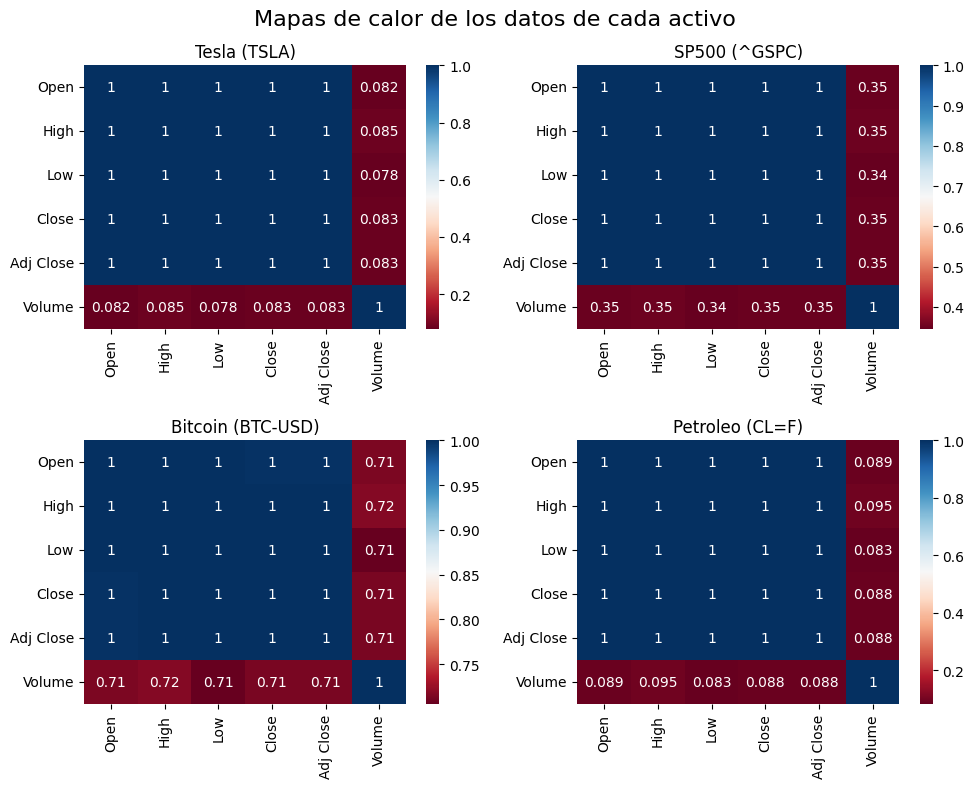

In [13]:
sns.set_palette('dark')

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))

sns.heatmap(datos_tesla.corr(), annot=True, cmap="RdBu", ax=axs[0, 0])
axs[0, 0].set_title('Tesla (TSLA)')
sns.heatmap(datos_sp500.corr(), annot=True, cmap="RdBu", ax=axs[0, 1])
axs[0, 1].set_title('SP500 (^GSPC)')
sns.heatmap(datos_bitcoin.corr(), annot=True, cmap="RdBu", ax=axs[1, 0])
axs[1, 0].set_title('Bitcoin (BTC-USD)')
sns.heatmap(datos_petroleo.corr(), annot=True, cmap="RdBu", ax=axs[1, 1])
axs[1, 1].set_title('Petroleo (CL=F)')

fig.suptitle('Mapas de calor de los datos de cada activo', fontsize=16)

plt.tight_layout()
plt.show()